# SAD — Séries Temporais: Média Móvel, SES, Holt e Holt-Winters

**Objetivo:** implementar do zero (sem bibliotecas prontas de séries) e comparar:
- **Média Móvel (MM)**
- **Suavização Exponencial Simples (SES)**
- **Holt** (nível + tendência)
- **Holt-Winters** (nível + tendência + sazonalidade; aditivo e multiplicativo)

**O que veremos:**
1) Como cada método funciona e como **escolhas de parâmetros** (janela `h`, `α`, `β`, `γ`, período `L`) **mudam os resultados**.  
2) **Avaliação** com MAE, MAPE, MSE e **gráficos** comparativos.  
3) **Previsões 1-passo-à-frente** (rolling) e **multi-passos**.

**Base:** Série real **AirPassengers** (nº de passageiros de voos internacionais mensais, 1949–1960).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Métricas ----------
def mae(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    eps = 1e-12
    return np.mean(np.abs((y_true - y_pred)/(y_true + eps))) * 100

def mse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred)**2)

# ---------- Plot ----------
def plot_series(df, cols, title, figsize=(10,4)):
    plt.figure(figsize=figsize)
    for c in cols:
        plt.plot(df.index, df[c], label=c)
    plt.title(title)
    plt.xlabel("Tempo")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()

,y
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


,y
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


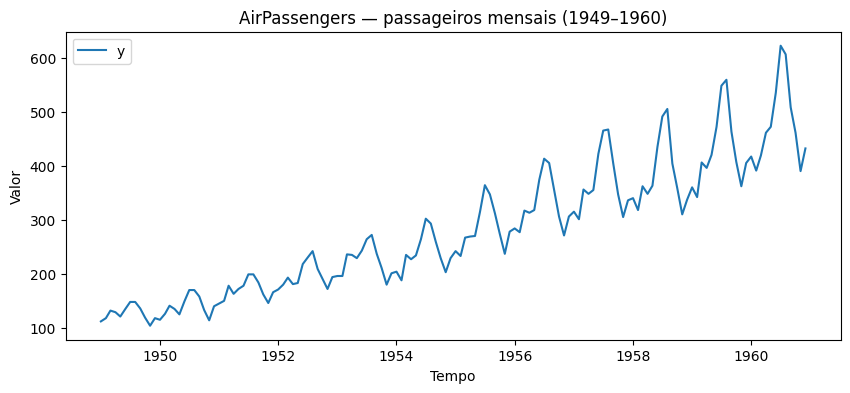

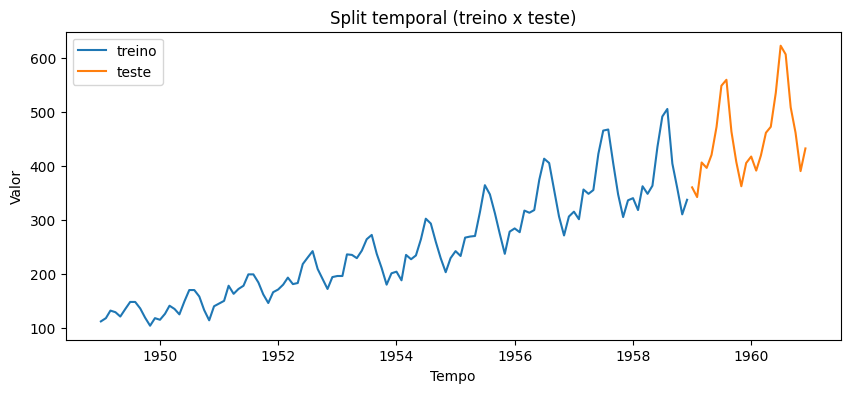

In [ ]:
# Fonte (repositório público): https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
air = pd.read_csv(url)

# Parse de data e index mensal
air["Month"] = pd.to_datetime(air["Month"])
air = air.rename(columns={"Passengers": "y"}).set_index("Month")
air = air.asfreq("MS")  # mês-início 

# Visualizar
display(air.head())
display(air.tail())

plot_series(air, ["y"], "AirPassengers — passageiros mensais (1949–1960)")

# Split treino/teste (últimos 24 meses para teste)
H_TEST = 24
train, test = air.iloc[:-H_TEST].copy(), air.iloc[-H_TEST:].copy()
plot_series(pd.concat([train.rename(columns={"y":"treino"}),
                       test.rename(columns={"y":"teste"})], axis=1),
            ["treino", "teste"], "Split temporal (treino x teste)")

In [3]:
air.shape

(144, 1)

## Revisão rápida

- **Erro**: $e_t = y_t - \hat{y}_t $ 
- **Métricas**: **MAE** (erro médio absoluto), **MAPE** (% relativo), **MSE** (erro quadrático).  
- **Componentes**: **nível ($s_t$)**, **tendência ($m_t$)** e **sazonalidade ($I_t$)**.  
- **Média Móvel (h)**: média das últimas $h$ observações → suaviza, mas cria **atraso (lag)**.  
- **SES**: $s_t = \alpha y_t + (1-\alpha) s_{t-1} $, previsão $\hat{y}_{t+1} = s_t $.  
- **Holt**: adiciona **tendência** $m_t$.  
- **Holt-Winters**: adiciona **sazonalidade** (período $L$), nas versões **aditiva** (amplitude ~ constante) e **multiplicativa** (amplitude proporcional ao nível).

## Média Móvel

In [4]:
def moving_average_forecast(series, h=3, horizon=1):
    """Previsão recursiva de 'horizon' passos com média das últimas h observações."""
    values = list(series)
    preds = []
    for _ in range(horizon):
        win = values[-h:] if len(values) >= h else values
        preds.append(np.mean(win))
        values.append(preds[-1])
    return np.array(preds)

def backtest_moving_average(train, test, h=3):
    """Rolling 1-step ahead: para cada ponto do teste, usa histórico até t-1."""
    preds, hist = [], list(train["y"].values)
    for y_true in test["y"].values:
        win = hist[-h:] if len(hist) >= h else hist
        y_hat = np.mean(win)
        preds.append(y_hat)
        hist.append(y_true) 
    return np.array(preds)

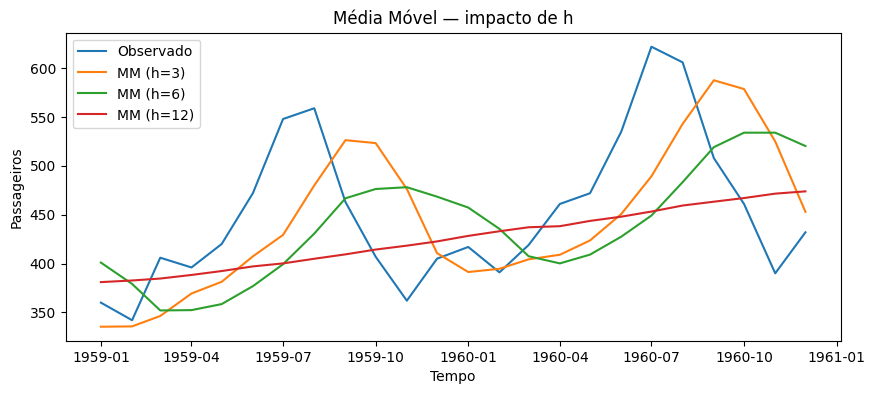

,MAE,MAPE,MSE
3,62.319444,13.514890,5626.476852
6,75.076389,16.289177,7645.802083
12,55.388889,11.345114,5521.688079


In [5]:
windows = [3, 6, 12]
mm_scores = {}

plt.figure(figsize=(10,4))
plt.plot(test.index, test["y"], label="Observado")

for h in windows:
    y_pred = backtest_moving_average(train, test, h=h)
    mm_scores[h] = {"MAE": mae(test["y"], y_pred),
                    "MAPE": mape(test["y"], y_pred),
                    "MSE": mse(test["y"], y_pred)}
    plt.plot(test.index, y_pred, label=f"MM (h={h})")

plt.title("Média Móvel — impacto de h")
plt.xlabel("Tempo"); plt.ylabel("Passageiros"); plt.legend(); plt.show()

display(pd.DataFrame(mm_scores).T)

## Suavização Exponencial Simples

In [6]:
def ses_fit(series, alpha, s0=None):
    """Retorna vetor s_t (nível) para a série."""
    y = np.array(series, dtype=float)
    s = np.zeros_like(y)
    s[0] = y[0] if s0 is None else s0
    for t in range(1, len(y)):
        s[t] = alpha * y[t] + (1 - alpha) * s[t-1]
    return s

def ses_backtest(train, test, alpha):
    preds, hist = [], list(train["y"].values)
    for y_true in test["y"].values:
        s = ses_fit(hist, alpha)
        preds.append(s[-1])  # 1 passo à frente
        hist.append(y_true)
    return np.array(preds)



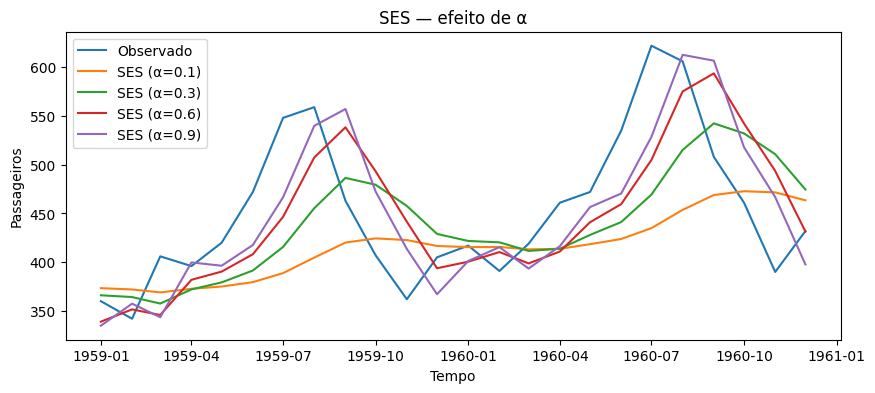

,MAE,MAPE,MSE
0.1,59.772574,12.154758,6429.315845
0.3,58.849973,12.537214,5145.216998
0.6,51.472885,11.162247,3807.046131
0.9,45.469741,9.994727,2883.871884


In [7]:
alphas = [0.1, 0.3, 0.6, 0.9]
ses_scores = {}

plt.figure(figsize=(10,4))
plt.plot(test.index, test["y"], label="Observado")

for a in alphas:
    y_pred = ses_backtest(train, test, alpha=a)
    ses_scores[a] = {"MAE": mae(test["y"], y_pred),
                     "MAPE": mape(test["y"], y_pred),
                     "MSE": mse(test["y"], y_pred)}
    plt.plot(test.index, y_pred, label=f"SES (α={a})")

plt.title("SES — efeito de α")
plt.xlabel("Tempo"); plt.ylabel("Passageiros"); plt.legend(); plt.show()

display(pd.DataFrame(ses_scores).T)

## Suavização Exponencial + Tendência (Holt)

In [8]:
def holt_fit(series, alpha, beta, s0=None, m0=None):
    y = np.array(series, dtype=float)
    s = np.zeros_like(y)
    m = np.zeros_like(y)

    # inicialização simples
    s[0] = y[0] if s0 is None else s0
    m[0] = (y[1] - y[0]) if m0 is None else m0

    for t in range(1, len(y)):
        s_old, m_old = s[t-1], m[t-1]
        s[t] = alpha * y[t] + (1 - alpha) * (s_old + m_old)
        m[t] = beta  * (s[t] - s_old) + (1 - beta) * m_old
    return s, m

def holt_backtest(train, test, alpha, beta):
    preds, hist = [], list(train["y"].values)
    for y_true in test["y"].values:
        s, m = holt_fit(hist, alpha, beta)
        y_hat = s[-1] + m[-1]        
        preds.append(y_hat)
        hist.append(y_true)
    return np.array(preds)

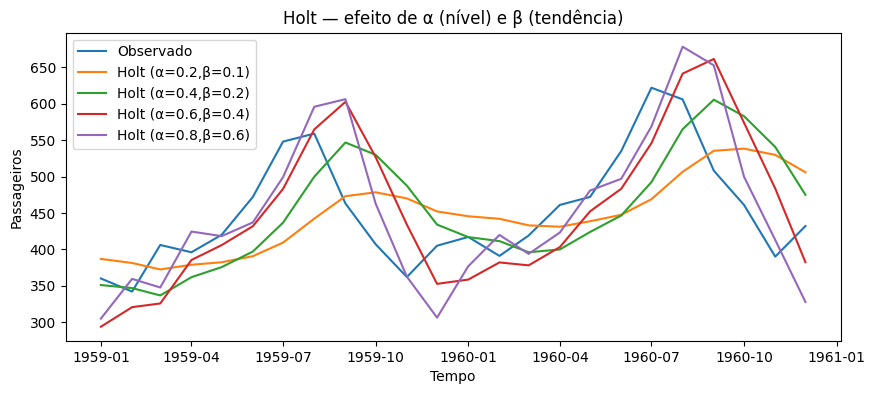

,,MAE,MAPE,MSE
0.2,0.1,64.307121,13.934944,5918.775199
0.4,0.2,66.389787,14.568741,6271.022520
0.6,0.4,60.275431,13.547194,5226.349837
0.8,0.6,49.813176,10.923146,3911.837198


In [9]:
pairs = [(0.2,0.1),(0.4,0.2),(0.6,0.4),(0.8,0.6)]
holt_scores = {}

plt.figure(figsize=(10,4))
plt.plot(test.index, test["y"], label="Observado")

for a,b in pairs:
    y_pred = holt_backtest(train, test, alpha=a, beta=b)
    holt_scores[(a,b)] = {"MAE": mae(test["y"], y_pred),
                          "MAPE": mape(test["y"], y_pred),
                          "MSE": mse(test["y"], y_pred)}
    plt.plot(test.index, y_pred, label=f"Holt (α={a},β={b})")

plt.title("Holt — efeito de α (nível) e β (tendência)")
plt.xlabel("Tempo"); plt.ylabel("Passageiros"); plt.legend(); plt.show()

display(pd.DataFrame(holt_scores).T)

## Holt-Winters (nível + tendência + sazonalidade)

Componente sazonal (período `L`):
- **Aditivo** (amplitude ~ constante):
  $$
  \begin{aligned}
  s_t &= \alpha (y_t - I_{t-L}) + (1-\alpha)(s_{t-1}+m_{t-1}) \\
  m_t &= \beta (s_t - s_{t-1}) + (1-\beta)m_{t-1} \\
  I_t &= \gamma (y_t - s_t) + (1-\gamma) I_{t-L} \\
  \hat{y}_{t+h} &= s_t + h\,m_t + I_{t-L+h}
  \end{aligned}
  $$
- **Multiplicativo** (amplitude proporcional ao nível):
  $$
  \begin{aligned}
  s_t &= \alpha \frac{y_t}{I_{t-L}} + (1-\alpha)(s_{t-1}+m_{t-1}) \\
  m_t &= \beta (s_t - s_{t-1}) + (1-\beta)m_{t-1} \\
  I_t &= \gamma \frac{y_t}{s_t} + (1-\gamma) I_{t-L} \\
  \hat{y}_{t+h} &= (s_t + h\,m_t)\, I_{t-L+h}
  \end{aligned}
  $$

**Inicialização (simples):**  
- $s_0$ = média da **primeira temporada**  
- $m_0 = \frac{1}{L^2} \sum_{i=0}^{L-1} (y_{L+i} - y_i)$  (tendência média por período)  
- Índices sazonais $I_i$ (para $i=0,\ldots,L-1$):  
  - **Aditivo:** $I_i = y_i - \bar{y}_{0:L}$  
  - **Multiplicativo:** $I_i = \frac{y_i}{\bar{y}_{0:L}}$

In [10]:
def init_hw(y, L, seasonal='add'):
    """Inicialização simples para HW a partir das primeiras 2 temporadas (se houver)."""
    y = np.array(y, dtype=float)
    if len(y) < 2*L:
        # se só houver 1 temporada, ainda funciona, mas pode ficar menos robusto
        base = y[:L]
        s0 = np.mean(base)
        if seasonal == 'add':
            I = np.array([yi - s0 for yi in base])
        else:
            I = np.array([yi / s0 if s0 != 0 else 1.0 for yi in base])
        # tendência a partir das primeiras diferenças médias (fallback simples)
        m0 = (np.mean(y[1:L]) - np.mean(y[:L-1])) if L > 1 else 0.0
    else:
        first, second = y[:L], y[L:2*L]
        s0 = np.mean(first)
        if seasonal == 'add':
            I = np.array([yi - s0 for yi in first])
        else:
            I = np.array([yi / s0 if s0 != 0 else 1.0 for yi in first])
        # tendência média entre temporadas (por período)
        m0 = (np.sum(second - first) / L) / L  # = (1/L^2) * sum(y_{L+i} - y_i)
    return s0, m0, I  # I tem tamanho L

def holt_winters_fit(y, alpha, beta, gamma, L, seasonal='add'):
    """
    Retorna (s, m, I) estimados ao longo da série.
    seasonal: 'add' ou 'mul'
    """
    y = np.array(y, dtype=float)
    n = len(y)
    s = np.zeros(n)
    m = np.zeros(n)
    I = np.zeros(n)

    s0, m0, I0 = init_hw(y, L, seasonal=seasonal)
    s[0], m[0] = s0, m0
    # preencher I[0:L] com I0
    I[:L] = I0

    for t in range(1, n):
        if t - L >= 0:
            if seasonal == 'add':
                s[t] = alpha * (y[t] - I[t-L]) + (1 - alpha) * (s[t-1] + m[t-1])
                m[t] = beta  * (s[t] - s[t-1]) + (1 - beta) * m[t-1]
                I[t] = gamma * (y[t] - s[t]) + (1 - gamma) * I[t-L]
            else:  # multiplicativo
                denom = I[t-L] if I[t-L] != 0 else 1.0
                s[t] = alpha * (y[t] / denom) + (1 - alpha) * (s[t-1] + m[t-1])
                m[t] = beta  * (s[t] - s[t-1]) + (1 - beta) * m[t-1]
                denom_s = s[t] if s[t] != 0 else 1.0
                I[t] = gamma * (y[t] / denom_s) + (1 - gamma) * I[t-L]
        else:
            # antes de completar um período, evoluir só nível e tendência (sem atualização sazonal)
            s[t] = alpha * y[t] + (1 - alpha) * (s[t-1] + m[t-1])
            m[t] = beta  * (s[t] - s[t-1]) + (1 - beta) * m[t-1]
            # manter I[t] como inicial (ou 0 para add, 1 para mul) — já atribuímos I[:L] = I0
    return s, m, I

def holt_winters_forecast_last(s, m, I, L, horizon=1, seasonal='add'):
    """
    Usa os últimos valores (s[-1], m[-1]) e os últimos L sazonais para projetar 'horizon' passos.
    """
    n = len(s)
    f = []
    for h in range(1, horizon+1):
        seasonal_index = I[n - L + (h % L)]  # ciclo sazonal
        base = s[-1] + h * m[-1]
        if seasonal == 'add':
            f.append(base + seasonal_index)
        else:
            f.append(base * seasonal_index)
    return np.array(f)

def hw_backtest(train, test, alpha, beta, gamma, L, seasonal='add'):
    """Rolling 1-step ahead para HW aditivo/multiplicativo."""
    preds = []
    hist = list(train["y"].values)
    for y_true in test["y"].values:
        s, m, I = holt_winters_fit(hist, alpha, beta, gamma, L, seasonal=seasonal)
        y_hat = holt_winters_forecast_last(s, m, I, L, horizon=1, seasonal=seasonal)[0]
        preds.append(y_hat)
        hist.append(y_true)
    return np.array(preds)

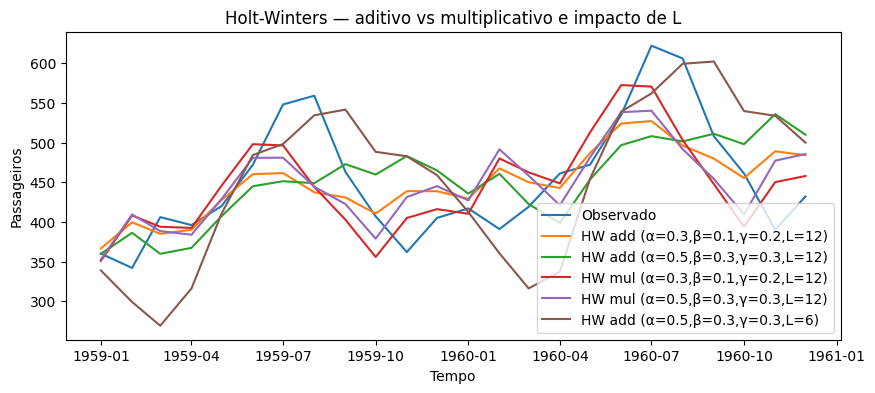

MAE       MAPE          MSE
add 0.3 0.1 0.2 12  42.423339   9.213671  3182.946132
mul 0.3 0.1 0.2 12  44.673875   9.737870  2864.388060
    0.5 0.3 0.3 12  46.943071  10.328998  3371.053937
add 0.5 0.3 0.3 12  54.270352  12.013548  4663.942775
                6   60.238744  14.078706  5504.836146

In [11]:
L_true = 12  # sazonalidade mensal
cfgs = [
    ("add", 0.3, 0.1, 0.2, 12),
    ("add", 0.5, 0.3, 0.3, 12),
    ("mul", 0.3, 0.1, 0.2, 12),
    ("mul", 0.5, 0.3, 0.3, 12),
    # período errado para mostrar impacto
    ("add", 0.5, 0.3, 0.3, 6),
]

hw_scores = {}

plt.figure(figsize=(10,4))
plt.plot(test.index, test["y"], label="Observado")

for seasonal, a, b, g, L in cfgs:
    y_pred = hw_backtest(train, test, alpha=a, beta=b, gamma=g, L=L, seasonal=seasonal)
    hw_scores[(seasonal, a, b, g, L)] = {
        "MAE": mae(test["y"], y_pred),
        "MAPE": mape(test["y"], y_pred),
        "MSE": mse(test["y"], y_pred)
    }
    plt.plot(test.index, y_pred, label=f"HW {seasonal} (α={a},β={b},γ={g},L={L})")

plt.title("Holt-Winters — aditivo vs multiplicativo e impacto de L")
plt.xlabel("Tempo"); plt.ylabel("Passageiros"); plt.legend(); plt.show()

display(pd.DataFrame(hw_scores).T.sort_values("MAE"))

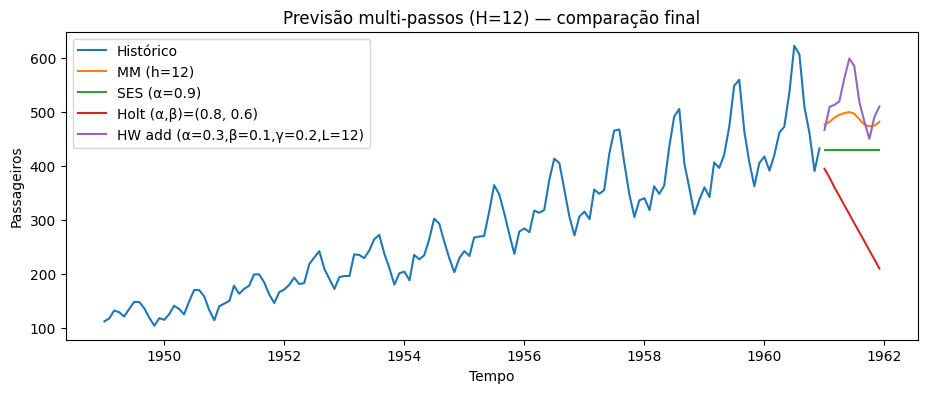

In [12]:
# Escolhas simples usando o melhor MAE encontrado acima (ajuste manual se quiser):
best_mm_h = min([3,6,12], key=lambda h: mae(test["y"], backtest_moving_average(train, test, h=h)))
best_ses_a = min([0.1,0.3,0.6,0.9], key=lambda a: mae(test["y"], ses_backtest(train, test, a)))
best_holt = min([(0.2,0.1),(0.4,0.2),(0.6,0.4),(0.8,0.6)], key=lambda ab: mae(test["y"], holt_backtest(train, test, ab[0], ab[1])))

# Escolher uma boa config HW pela tabela anterior:
best_hw_key = min(hw_scores, key=lambda k: hw_scores[k]["MAE"])
best_seasonal, a, b, g, L = best_hw_key

# Treinar em TODO o histórico e prever horizonte H=12
H_FORE = 12
history_full = air["y"].values

# MM
mm_fore = moving_average_forecast(history_full, h=best_mm_h, horizon=H_FORE)

# SES
s = ses_fit(history_full, best_ses_a)
ses_fore = np.repeat(s[-1], H_FORE)

# Holt
s_h, m_h = holt_fit(history_full, best_holt[0], best_holt[1])
holt_fore = np.array([s_h[-1] + (h)*m_h[-1] for h in range(1, H_FORE+1)])

# HW
s_hw, m_hw, I_hw = holt_winters_fit(history_full, a, b, g, L, seasonal=best_seasonal)
hw_fore = holt_winters_forecast_last(s_hw, m_hw, I_hw, L, horizon=H_FORE, seasonal=best_seasonal)

future_idx = pd.date_range(air.index[-1] + pd.offsets.MonthBegin(1), periods=H_FORE, freq="MS")

plt.figure(figsize=(11,4))
plt.plot(air.index, air["y"], label="Histórico")
plt.plot(future_idx, mm_fore, label=f"MM (h={best_mm_h})")
plt.plot(future_idx, ses_fore, label=f"SES (α={best_ses_a})")
plt.plot(future_idx, holt_fore, label=f"Holt (α,β)={best_holt}")
plt.plot(future_idx, hw_fore, label=f"HW {best_seasonal} (α={a},β={b},γ={g},L={L})")
plt.title("Previsão multi-passos (H=12) — comparação final")
plt.xlabel("Tempo"); plt.ylabel("Passageiros"); plt.legend(); plt.show()

## Como interpretar

- **Média Móvel**: janelas maiores (ex.: `h=12`) suavizam mais, mas atrasam a curva.
- **SES (α)**: α alto reage rápido (pode ficar ruidoso); α baixo é mais suave (pode atrasar em tendência).
- **Holt (α, β)**: melhora quando há **tendência**; β mais alto reage mais à inclinação, mas pode oscilar.
- **Holt-Winters (α, β, γ, L)**:
  - **Aditivo**: bom quando a amplitude sazonal é aproximadamente constante.
  - **Multiplicativo**: melhor quando a amplitude cresce com o nível (como em AirPassengers).
  - **Período L incorreto** (ex.: 6 em vez de 12) degrada claramente as previsões.
- **Gráficos + Métricas**: olhe os dois — MAE/MAPE/MSE e o **ajuste visual** (picos/vales, tendência).

# Exercícios

1) **Média móvel centrada**  
   (a) Implemente a versão **centrada** (quando possível) para `h=5` e `h=11`.  
   (b) Compare com a não-centrada em termos de uso para **análise** vs **previsão**.

2) Monte uma busca em grade (grid search):  
   - MM: `h ∈ {3,6,9,12}`  
   - SES: `α ∈ {0.1, 0.2, ..., 0.9}`  
   - Holt: `α ∈ {0.2,0.4,0.6}`, `β ∈ {0.1,0.3,0.5}`  
   - HW: teste aditivo e multiplicativo com `L=12`, variando `α, β, γ ∈ {0.2,0.4,0.6}`  
   Reporte **MAE, MAPE, MSE** e mostre um **gráfico** por método com os melhores parâmetros.

3) Insira 3 outliers no treino e re-treine os modelos. O que muda?

4) Baixe outra série mensal (ex.: vendas, energia, tráfego) e replique o pipeline, discutindo diferenças em sazonalidade e tendência.

5) Qual método e parametrização você escolheria *para AirPassengers* e por quê? Use **gráficos** e **métricas** para justificar.